Surface

In [1]:
# import numpy as np

# Sx=np.gradient(surface[0,:,:],axis=0)
# Sy=np.gradient(surface[0,:,:],axis=1)
# # print(norm.cdf(Sx))
# import matplotlib.pyplot as plt
# plt.hist(Sx.flatten(), bins=50, density=True, alpha=0.5, label="Upwind Slopes");
# plt.hist(Sy.flatten(), bins=50, density=True, alpha=0.5, label="Crosswind Slopes");
# plt.legend()
# print(f"Variance of slopes {np.var(Sx.flatten())+np.var(Sy.flatten())}")
# A=(np.power(wavenumbers,2)*spectrum).reshape(-1,1)*spreading

# print(f"Integral {np.trapz(np.trapz(A,wavenumbers, axis=0), x=theta, axis=0)}")      


In [2]:
import matplotlib.pyplot as plt
from omnidirectional_spectrum import spectrum_model
from spreading_function import spreading_model
import numpy as np
spectrum=spectrum_model.JONSWAP
spreading=spreading_model.Longuet_Higgins
n=2
S=8
length=256
N=256
wind_speed=10
wind_direction=0
seconds=5
timestep=0.5
fetch=80000
elfouhaily_k=0.1

In [3]:

from surface import surfaceGenerator
surfaceGenerator=surfaceGenerator(spectrum, spreading, length, N, wind_speed, wind_direction, n, S, seconds, timestep, fetch, elfouhaily_k)
Z=surfaceGenerator.generate()


256
1.0
256


Surface Variances [0.2246248279658507, 0.22452299862031816, 0.2246367443733281, 0.22478455384496424, 0.22472301340471076, 0.22460673998403521, 0.22459210414385472, 0.22467722114045113, 0.2247404027365707, 0.224658265556191]
Spectrum Integral 0.1705043464899063
Slope Variances 0.012143062994997702
Slope Integral 0.002780548995360732
Significant wave height [1.8957840719484935, 1.895354314613785, 1.8958343572087857, 1.8964579777889696, 1.8961983584201765, 1.895707741120599, 1.8956459759938498, 1.896005152484354, 1.8962717220338259, 1.8959251696464858]


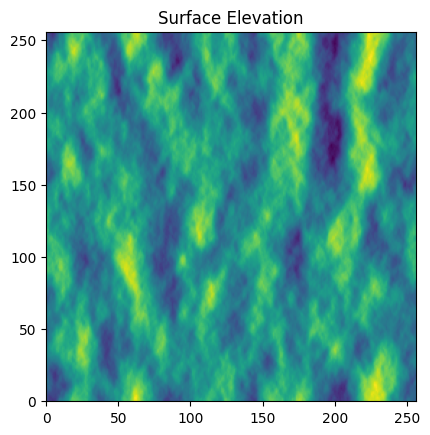

In [4]:
#plt.imshow(Z[0,:,:],extent=[0,length,0,length], origin='lower')
import imageio
from matplotlib.animation import FuncAnimation
# with imageio.get_writer('wave_field.gif', mode='I') as writer:
#     for surface in Z:
#         plt.imshow(surface,extent=[0,length,0,length], origin='lower', cmap='viridis')
#         plt.pause(0.1)
#         plt.close()
#         writer.append_data((surface*255).astype(np.uint8))
# Create a figure and axis
fig, ax = plt.subplots()
fig.set_dpi(100)
# Function to update the plot for each frame
def update(frame):
    ax.clear()  # Clear previous frame
    im=ax.imshow(Z[frame], cmap='viridis', extent=[0, length, 0, length], origin='lower')  # Plot elevation data
    ax.set_title(f'Surface Elevation')  # Set title

# Create the animation
ani = FuncAnimation(fig, update, frames=len(Z), interval=200)

# Save the animation as a GIF using imageio
filename = 'elevation_animation.mp4'
ani.save(filename, writer='ffmpeg')
# with imageio.get_writer(filename, mode='I') as writer:
#     for i, x in enumerate(Z):
#         update(i)  # Update plot for each frame
#         fig.canvas.draw()  # Redraw the figure
#         image = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8')
#         image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))[:, :, :3]
#         writer.'append_data(image)  # Append frame to GIF
#     plt.close(fig)
print(f"Surface Variances {surfaceGenerator.getSurfaceVariances()}")
print(f"Spectrum Integral {surfaceGenerator.getSpectrumIntegral()}")
print(f"Slope Variances {surfaceGenerator.getSlopes()}")
print(f"Slope Integral {surfaceGenerator.getSlopeIntegral()}")
print(f"Significant wave height {surfaceGenerator.getSignificantWaveHeights()}")

/home/eltjon/Thesis/OceanSARImagingSimulator/SAR_imaging.py:23: RuntimeWarning: invalid value encountered in divide
  return 4.5*self.omega*(self.k*np.sin(self.theta))**2*(self.omega-self.mu*1j)/(np.abs(self.k)*(self.omega**2+self.mu**2))


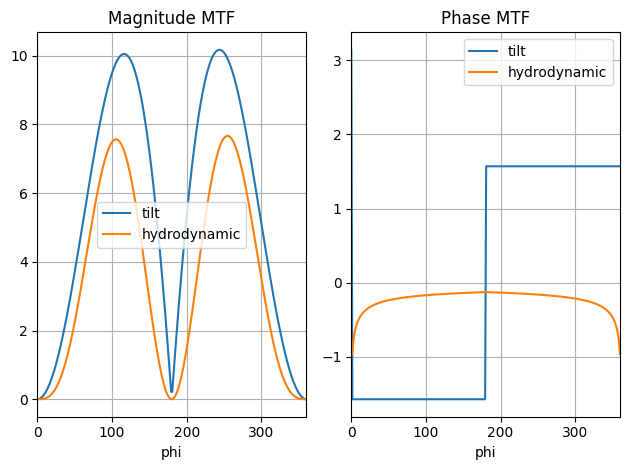

In [5]:
from SAR_imaging import SAR_imaging

k=surfaceGenerator.k
sar=SAR_imaging(Z[0,:,:], surfaceGenerator.PSI, np.pi/6, surfaceGenerator.k, surfaceGenerator.omega)   
#-(4*np.cos(self.look_angle)/np.sin(self.look_angle))/(1+np.sin(self.look_angle)**2)*(1j*self.ky)

tilt=sar.tilt()#4.5*surfaceGenerator.omega[0,:]*(surfaceGenerator.k[0,:]*np.sin(theta))**2*(surfaceGenerator.omega[0,:]-0.01*1j)/(np.abs(surfaceGenerator.k[0,:])*(surfaceGenerator.omega[0,:]**2+0.1**2))
hydrodynamic=sar.hydrodynamic()
plt.subplot(1, 2, 1)
plt.plot(np.linspace(0,360,256),np.abs(tilt), label="tilt")
plt.plot(np.linspace(0,360,256),np.abs(hydrodynamic), label="hydrodynamic")
plt.xlim(0, 360)
plt.xlabel('phi')
plt.title('Magnitude MTF')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.linspace(0,360,256),np.angle(tilt), label="tilt")
plt.plot(np.linspace(0,360,256),np.angle(hydrodynamic), label="hydrodynamic")
plt.xlim(0, 360)
plt.xlabel('phi')
plt.title('Phase MTF')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
surfaceGenerator.omnidirectional_spectrum.plot()
# surfaceGenerator.spreading_function.plot()

In [ ]:
from superImposition_surface import superImpositionSurfaceGenerator

superImpositionSurfaceGenerator=superImpositionSurfaceGenerator(spectrum, spreading, length, N, wind_speed, wind_direction, n, S, 1, 1, fetch, elfouhaily_k)
ZZ=superImpositionSurfaceGenerator.generate()

In [ ]:
plt.imshow(ZZ[0,:,:],extent=[0,length,0,length])
plt.gca().invert_yaxis()
plt.colorbar()
print(f"Surface Variances {superImpositionSurfaceGenerator.getSurfaceVariances()}")
print(f"Spectrum Integral {superImpositionSurfaceGenerator.getSpectrumIntegral()}")
print(f"Slope Variances {superImpositionSurfaceGenerator.getSlopes()}")
print(f"Slope Integral {superImpositionSurfaceGenerator.getSlopeIntegral()}")
print(f"Significant wave height {superImpositionSurfaceGenerator.getSignificantWaveHeights()}")

In [ ]:
superImpositionSurfaceGenerator.omnidirectional_spectrum.plot()
# superImpositionSurfaceGenerator.spreading_function.plot()

In [ ]:
from SAR_imaging import SAR_imaging
theta=np.linspace(0, 2*np.pi, 500)
costheta=np.sin(theta)
k=superImpositionSurfaceGenerator.wavenumbers
sar=SAR_imaging(ZZ[0,:,:], superImpositionSurfaceGenerator.PSI, np.pi/3, (k*costheta), superImpositionSurfaceGenerator.omega)   
tilt=sar.tilt()
plt.subplot(1, 2, 1)
plt.plot(abs(tilt))
plt.xlabel('phi')
plt.title('Magnitude MTF')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(np.angle(tilt))
plt.xlabel('phi')
plt.title('Phase MTF')
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# fig, (ax1,ax2, ax3, ax4, ax5)=plt.subplots(1,5)
# ax1.contour(surfaceGenerator.KX, surfaceGenerator.KY, surfaceGenerator.getPSI())
# ax1.set_xlim(-0.5,0.5)
# ax1.set_ylim(-0.5,0.5)

# ax2.imshow(Z[0,:,:], origin="lower")

# ax3.imshow(abs(np.fft.fftshift(np.fft.fft2(Z[0,:,:])))**2)
# ax3.set_xlim(100,150)
# ax3.set_ylim(100,150)

# ax4.imshow(np.real(np.fft.fftshift(np.fft.fft2(Z[0,:,:]))))
# ax4.set_xlim(100,150)
# ax4.set_ylim(100,150)
# ax5.imshow(np.imag(np.fft.fftshift(np.fft.fft2(Z[0,:,:]))))
# ax5.set_xlim(100,150)
# ax5.set_ylim(100,150)


# # ax2.gca().invert_yaxis()
# # plt.colorbar()
# kx=surfaceGenerator.KX[0,:]
# # print()
# print(np.trapz(np.trapz(surfaceGenerator.getPSI(), surfaceGenerator.KX[0,:], axis=0), surfaceGenerator.KY[:,0]))
# print(np.var(Z[0,:,:]))

In [ ]:
# %matplotlib widget
# from matplotlib.animation import FuncAnimation
# fig, ax = plt.subplots()
# L=512
# img = ax.imshow(Z[0,:,:], cmap='viridis',extent=[0, L, 0, L])
# # cbar=fig.colorbar(img)
# def update(frame):
#     img.set_data(Z[int(frame),:,:])  # Update the image data
#     ax.set_title(u"Frame {}°".format(frame))
#     return img,

# # Create the animation
# ani = FuncAnimation(fig, update, frames=10, interval=1)

# plt.show()

In [ ]:
a=np.array([1,2,3,4,5])
b=np.array([3,4,5])
print(a.reshape(-1,1)*b)
tmp, _=np.meshgrid(a,b)
print(tmp)